# Compare Ship and to Himawari SST (IR)

In [32]:
import os
import glob
from importlib import reload

import numpy as np

import xarray
import pandas
import healpy

from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
import seaborn as sns

from remote_sensing.healpix import rs_healpix
from remote_sensing.plotting import utils as plot_utils

import ship

In [2]:
lon_lim = (127.,134)
lat_lim = (18.,23)

# Grab Satellite data

In [5]:
reload(rs_healpix)
h09_file = os.path.join(os.getenv('OS_RS'), 'PODAAC', 'H09-AHI-L3C-ACSPO-v2.90',
                          '20250212220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc')
h09 = rs_healpix.RS_Healpix.from_dataset_file(h09_file,  'sea_surface_temperature',
            lat_slice=slice(23.,18),  lon_slice=slice(127., 134.))

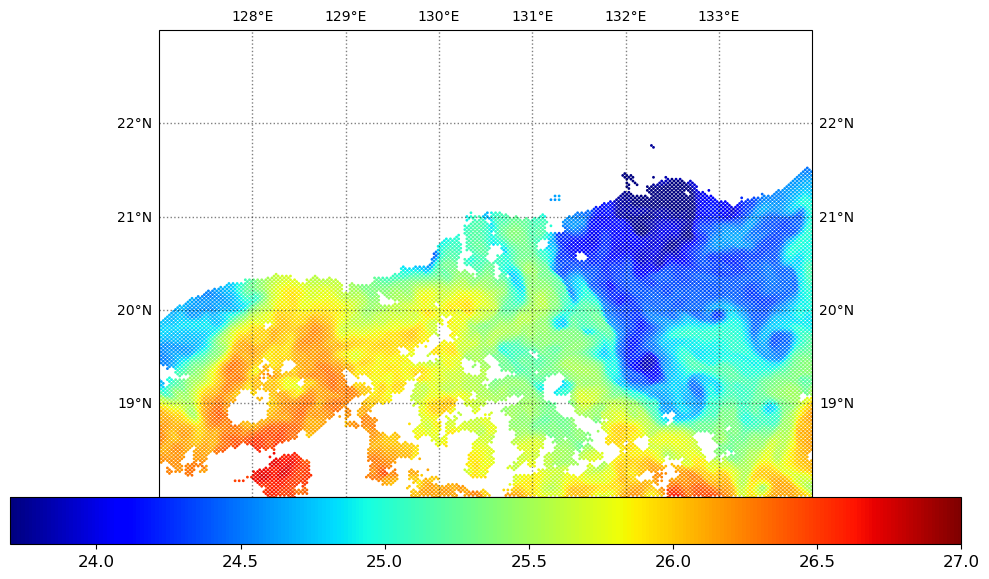

(<GeoAxes: >, <matplotlib.collections.PathCollection at 0x7c13d2bf2870>)

In [6]:
h09.plot(figsize=(10.,6), cmap='jet', 
        lon_lim=lon_lim, lat_lim=lat_lim, 
        projection='platecarree', #ssize=40., 
        vmin=23.7, vmax=27., show=True)

# Load ship data

In [8]:
reload(ship)
ship_data = ship.load_ship()

# Match up

In [11]:
h09.time.size

1

In [16]:
pandas.to_datetime(h09.time)[0]

Timestamp('2025-02-12 22:00:00')

In [22]:
ship_t = pandas.to_datetime(ship_data.time)
dt = ship_t - pandas.to_datetime(h09.time)[0]
close_t = np.abs(dt) < pandas.Timedelta('1 hours')
np.sum(close_t)

np.int64(7199)

# Temperatures

## Calculate from H09

In [23]:
ship_lons, ship_lats = ship_data.lon.values[close_t], ship_data.lat.values[close_t] 

In [25]:
h09T_at_ship = healpy.pixelfunc.get_interp_val(
            h09.hp, ship_lons, ship_lats, lonlat=True)

In [26]:
DT = ship_data.temperatureInlet[close_t].values - h09T_at_ship

# Plot me

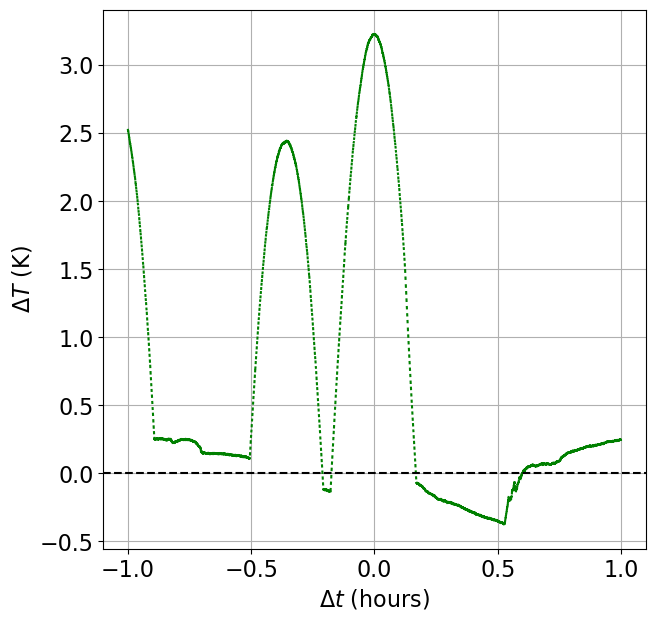

Mean DT = 0.7081116077530685


In [33]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()

x_hours = dt[close_t].total_seconds() / 3600

ax.plot(x_hours, DT, color='green')
#
ax.axhline(0., color='k', ls='--')
ax.set_xlabel(r'$\Delta t$ (hours)')
ax.set_ylabel(r'$\Delta T$ (K)')
#ax.xaxis.set_major_formatter(FuncFormatter(timedelta_to_hours))
ax.xaxis.set_major_locator(MultipleLocator(0.5))  # Major ticks every 2 units


plot_utils.set_fontsize(ax, 16.)
ax.grid()

plt.show()
#
print(f'Mean DT = {np.nanmean(DT)}')


## Plot the ship

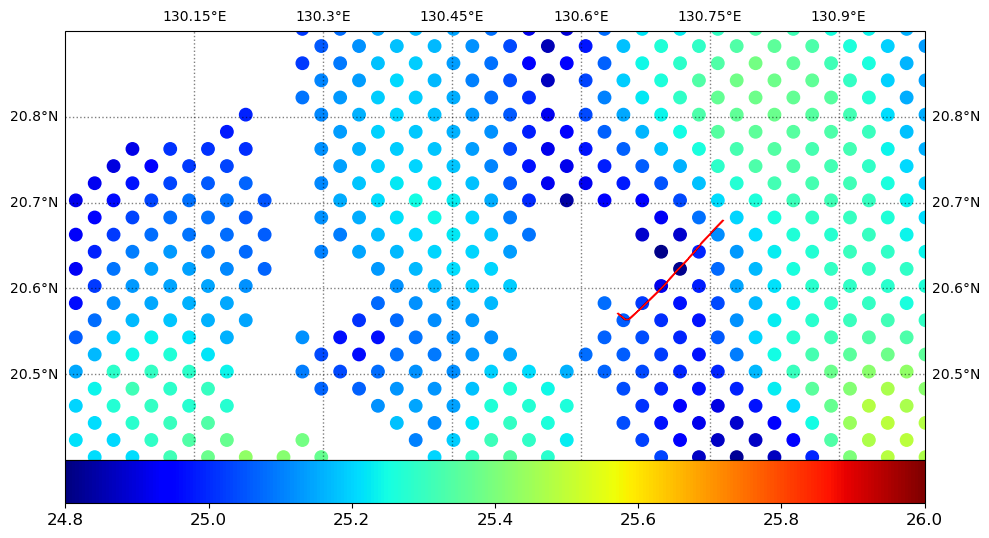

In [34]:
ax, img = h09.plot(figsize=(10.,6), cmap='jet', 
       lon_lim=(130.,131.), lat_lim=(20.4,20.9),
        projection='platecarree', ssize=80., 
        vmin=24.8, vmax=26., show=False)
# Add ship
ax.plot(ship_lons, ship_lats, 'x', color='r', ms=0.1)
#
plt.show()